# Higgs Tweet - Preprocessing

### Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os, sys, datetime
import pandas as pd
import nbimporter

### Read Social Graph

In [2]:
"""Load complete unweighted social network graph"""

def load_social_graph():
    G = nx.read_edgelist("./Data/higgs-social_network.edgelist",
                     create_using=nx.MultiDiGraph(), nodetype=int, data=(("kind", str),))
    # Add Friendship label to each edge in the loaded graph
    nx.set_edge_attributes(G, "FR", "kind")
    return G

G = load_social_graph()
print("Graph loaded:")

Graph loaded:


In [4]:
"""Test Graph"""

print(len(G))
print(len(G.edges))
print(nx.__version__)

456626
14855842
2.0


### Read Action Log

In [6]:
"""Read action log into a pandas dataframe"""

def dateparse (timestamp):    
    return datetime.datetime.fromtimestamp(float(timestamp))

def read_log():
    log = pd.read_csv("./Data/higgs-activity_time.txt", delimiter=" ",
                      index_col="time", parse_dates=True, date_parser=dateparse)
    return log

log = read_log()
print(log.shape[0])
print(log.head())

563069
                      user1   user2 type
time                                    
2012-06-30 17:02:52  223789  213163   MT
2012-06-30 17:02:52  223789  213163   RE
2012-06-30 17:06:21  376989   50329   RT
2012-06-30 17:06:23   26375  168366   MT
2012-06-30 17:06:32  376989   13813   RT


### Add action edges to the graph

In [7]:
"""Add action edges to the social graph"""

def add_log_edges_to_social_graph(G, log):
    """
    Input is a MultiDiGraph, log is a pandas dataframe,
    Output is a MultiDiGraph with more edges
    """
    for date, action in log.iterrows():
        G.add_edge(action["user1"], action["user2"], kind=action["type"])
    return G


print(len(G.edges))
G = add_log_edges_to_social_graph(G, log)
print(len(G.edges))

14855842
<class 'pandas.core.frame.DataFrame'>
15418911


### Print edge-types

In [8]:
def count_and_print_actions_in_graph(G):
    follow = 0
    retweet = 0
    mention = 0
    reply = 0

    for u, v, attributes in G.edges(data=True): 
        if "kind" in attributes:
            if attributes["kind"] == "RT":
                retweet += 1
            elif attributes["kind"] == "MT":
                mention += 1
            elif attributes["kind"] == "FR":
                follow += 1
            elif attributes["kind"] == "RE":
                reply += 1
            else:
                print("Whaaat!")
        else:
            #pass
            sys.exit("Whoa, stop!")
    print("The distribution over FR, RT, MT, RE is")
    print(follow, retweet, mention, reply)
    print("Total number of edges is")
    print(follow + retweet + mention + reply)
    print("(should be ={})".format(len(G.edges)))

count_and_print_actions_in_graph(G)

The distribution over FR, RT, MT, RE is
14855842 354930 171237 36902
Total number of edges is
15418911
(=15418911)


In [9]:
"""Create DiGraph (tar litt tid..)"""

def create_digraph(G):
    """
    G is a typed multidigraph. 
    Build a weighted digraph by combining parallel edges
    """
    kind_weights = {"RT" : 0.01, "RE" : 0.01, "RT" : 0.01, "MT" : 0.01, "FR" : 0.00}

    D = nx.DiGraph()
    D.add_nodes_from(G)
    nx.set_edge_attributes(D, 0.0, "weight")

    for u in G:
        for v in G.predecessors(u):
            edges = dict(G[v][u])
            weight = 0.0
            for edge in edges.values():
                kind = edge["kind"]
                weight += kind_weights[kind]
            weight = np.min((weight, 1.0))
            if weight != 0:
                D.add_edge(u, v, weight=weight)
    return D

print(len(G.nodes))
D = create_digraph(G)
print(len(G.nodes))
print(len(D.edges))

weights = list(nx.get_edge_attributes(D, "weight").values())

456626
456626
466545


466545


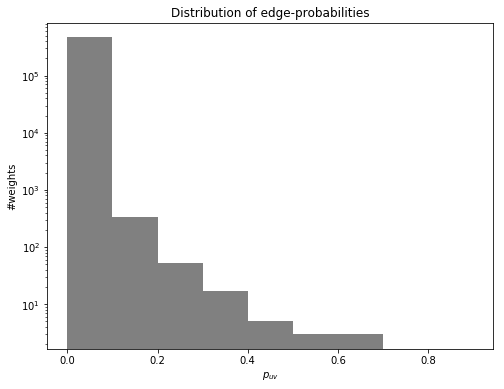

In [31]:
print(len(weights))
plt.figure(1, figsize=(8,6))
plt.hist(weights[:], bins=np.arange(0.0, 1.0, 0.1), color="gray")
plt.yscale('log', nonposy='clip')
plt.xlabel("$p_{uv}$")
plt.ylabel("#weights")
plt.title("Distribution of edge-probabilities")
plt.savefig("Report/Figures/puv_dist.png", bbox_inches="tight")
plt.show()

In [11]:
nx.write_weighted_edgelist(D, "Data/higggs-complete-graph.edgelist")

X = nx.read_weighted_edgelist("Data/higggs-complete-graph.edgelist")
print(len(X))
print(len(X.edges))

304691
454878


## Plot Degree Distributions

In [40]:
"""Plot summary stats: Degree Distributions""" 

in_degree = sorted([d for (n, d) in G.in_degree()], reverse=True)
out_degree = sorted([d for (n, d) in G.out_degree()], reverse=True)
degree = sorted([d for (n, d) in G.degree()], reverse=True)

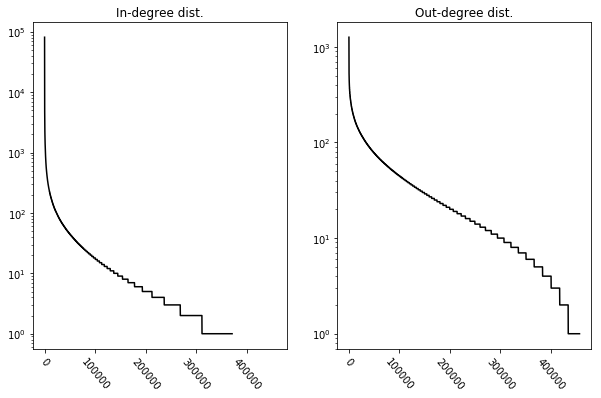

In [68]:
fig = plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.semilogy(range(len(G)), in_degree, color="k")
plt.title("In-degree dist.")

plt.subplot(1, 2, 2)
plt.semilogy(range(len(G)), out_degree, color="k")
plt.title("Out-degree dist.")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=310)

plt.show()

## Write top-k nodes to file (in_deg & deg)

In [13]:
def sort_by_value(arr):
    return arr[np.argsort(-arr[:, 1])]

def get_top_k_indeg(G, k):
    _in =  np.array(G.in_degree()).astype(np.float)
    _in = sort_by_value(_in)
    return _in[0:k, 0]

def get_top_k_deg(G, k):
    _deg =  np.array(G.degree()).astype(np.float)
    _deg = sort_by_value(_deg)
    return _deg[0:k, 0]

def strip_decimal(s):
    return str(s)[:-2]


In [14]:
"""Output seed-sets of different sizes for different heuristics"""

K = 50

for k in range(1, K+1):

    S = get_top_k_indeg(G, k)

    #S = list(map(strip_decimal, S))
    np.save("Data/seeds/in_deg/in_deg{}.npy".format(k), S)
    
    S = get_top_k_deg(G, k)
    #S = list(map(strip_decimal, S))
    np.save("Data/seeds/deg/deg{}.npy".format(k), S)



## Read and Summarize Activity Log

## Write top-k influencial users to file

In [ ]:
def get_top_k_infl(G, k):
    influence = np.array([[u, num_times_spread(u)] for u in G]).astype(np.float)
    influence = sort_by_value(influence)
    return influence[0:k, 0]

K = 50
top_K_influence = get_top_k_infl(G, K)
top_K_influence = list(map(strip_decimal, top_K_influence))

for k in range(1, K+1):
    np.save("Data/seeds/infl/infl{}.npy".format(k), top_K_influence[0:k])
    

In [ ]:
print(top_K_influence[0:10])
print([num_times_spread(u) for u in top_K_influence[0:10]])

## Compute and plot spreads for deg, in_deg & infl

In [ ]:
rand_seeds = []

for i in range(1, 51):
    rand_seeds.append(np.random.choice(list(G.nodes.keys())))
    np.save("Data/seeds/rand/rand{}.npy".format(i), rand_seeds)


In [ ]:
from spread import *

num_seeds = list(range(1, 50))
indeg_spreads = []
deg_spreads = []
infl_spreads = []
rand_spreads = []

for i in num_seeds:
    print("Computing spreads for {} seeds".format(i))
    indeg_seeds = np.load("Data/seeds/in_deg/in_deg{}.npy".format(i))
    #deg_seeds = np.load("Data/seeds/deg/deg{}.npy".format(i))
    #infl_seeds = np.load("Data/seeds/infl/infl{}.npy".format(i))
    rand_seeds = np.load("Data/seeds/rand/rand{}.npy".format(i))
    
    (indeg_n, _) = get_expected_spread(G, indeg_seeds, 100, mean=True)
    #(deg_n, _) = get_expected_spread(G, deg_seeds, 100, mean=True)
    (rand_n, _) = get_expected_spread(G, rand_seeds, 100, mean=True)
    #(infl_n, _) = get_expected_spread(G, infl_seeds, 100, mean=True)
    
    indeg_spreads.append(indeg_n)
    #deg_spreads.append(deg_n)
    rand_spreads.append(rand_n)
    #infl_spreads.append(infl_n)
    
os.system("printf '\a'")

plt.plot(num_seeds, indeg_spreads, c='k')
#plt.plot(num_seeds, deg_spreads, c='b')
plt.plot(num_seeds, rand_spreads, c='y')
#plt.plot(num_seeds, infl_spreads, c='r')

plt.show()

In [ ]:
plt.plot(num_seeds, indeg_spreads, c='k')
plt.plot(num_seeds, deg_spreads, c='b')
plt.plot(num_seed, infl_spreads, c='r')
plt.plot(num_seeds, rand_spreads, c='y')

plt.show()

np.save("Data/spreads/rand_spreads", indeg_spreads)
np.save("Data/spreads/indeg_spreads", indeg_spreads)
np.save("Data/spreads/deg_spreads", deg_spreads)
np.save("Data/spreads/infl_spreads", infl_spreads)

In [ ]:
print(nx.__version__)

print(np.median([d for (_, d) in G.out_degree()]))
print(nx.number_connected_components(G.to_undirected()))

C = nx.connected_components(G.to_undirected())

print([len(c) for c in C])